In [1]:
using Optim, Distributions, Plots

# Monte-Carlo Evaluation of Direct Estimation vs Relative Demand

## Data Generating Process

The outcome $y$ is generated by a CES technology:

$$ y = (a x_{1}^\rho + (1-a)x_{2}^\rho)^{\delta/\rho}\exp(\xi) $$

where $\xi\sim\mathcal{N}(0,\sigma^2_\xi)$. 

We assume that

$$\log(x_{1}) \sim \mathcal{N}(3,1) $$

and that $x_{2}$ is chosen optimally relative to $x_{1}$:

$$ \frac{x_{2}}{x_{1}} = \left(\frac{a}{1-a}\pi\right)^{1/(\rho-1)} $$

where $\pi$ is the relative price. We assume that

$$ \log(\pi) \sim\mathcal{N}(0,\sigma^2_{\pi})$$

In some cases, we will assume that $\log(x_{2})$ is only observed with measurement error:

$$ \log(x_{2}^{o}) = \log(x_{2}) + \zeta $$

with $\zeta \sim \mathcal{N}(0,\sigma^2_{\zeta})$.

Below is a function to generate the data according to this setup.

In [2]:
function gen_data(p,N)
    (;ρ, a, δ, σξ, σπ, σζ) = p
    rel_price = rand(LogNormal(0,σπ),N)
    x1 = rand(LogNormal(3.,1.),N)
    x2 = (a/(1-a))^(1/(ρ-1)) .* rel_price.^(1/(ρ-1)) .* x1
    logy = δ * log.( (a .* x1 .^ ρ .+ (1 - a) .* x2 .^ ρ ) .^ (1/ρ) ) .+ rand(Normal(0,σξ),N)
    logx2_obs = log.(x2) .+ rand(Normal(0,σζ),N)
    return (;logy,x1,x2,logx2_obs,rel_price)
end

gen_data (generic function with 1 method)

## The Estimators

We evaluate the performance of four estimators:

1. A NLLS estimator for $\rho$ only using outcomes assuming the values of $a$ and $\delta$ are known and assuming no measurement error in inputs.
2. A NLLS estimator for $(a,\delta,\rho)$ using only outcomes and assuming no measurement error in inputs.
3. A NLLS estimator for $(a,\delta,\rho)$ and $(\tilde{a},\tilde{\rho})$ that assumes measurement error in $x_{2}$, uses relative demand as well as outcomes, but **does not** impose the cross-equation restrictions between technology and demand.
4. A NLLS estimator for $(a,\delta,\rho)$ that assumes measurement error in $x_{2}$, uses relative demand as well as outcomes and **does** impose the cross-equation restrictions.

The code below presents the objective functions for each of these four estimators.

In [3]:
# this function works for both estimators 1 and 2.
function Q1_nlls(p,data)
    (;logy,x1,x2) = data
    (;ρ,a,δ) = p
    r2 = logy .- δ * log.( (a .* x1 .^ ρ .+ (1 - a) .* x2 .^ ρ) .^ (1/ρ) )
    return sum(r2.^2)
end

# this function works for estimators 3 and 4
function Q2_nlls(p1,p2,data)
    # p1 are the perceived parameters of technology
    # p2 are the true parameters of technology
    (;logy,x1,logx2_obs,rel_price) = data
    (;δ) = p2
    r1 = logx2_obs .- log.(x1) .- (1/(p1.ρ-1))*log(p1.a/(1-p1.a)) .- (1/(p1.ρ-1))*log.(rel_price)
    x2 = (p1.a/(1-p1.a))^(1/(p1.ρ-1)) .* rel_price.^(1/(p1.ρ-1)) .* x1
    r2 = logy .- δ * log.( (p2.a .* x1 .^ p2.ρ .+ (1 - p2.a) .* x2 .^ p2.ρ) .^ (1/p2.ρ) )
    return sum(r1.^2) + sum(r2.^2)
end


Q2_nlls (generic function with 1 method)

## Parameterization

In addition to choosing $\log(x_1)\sim\mathcal{N}(3,1)$, in the simulation we specify that

$$ \rho = -2,\ a = 0.5,\ \delta = 0.2,\ \sigma_{\xi} = 0.3,\ \sigma_{\zeta} = 0.3$$

which fixes the elasticity of substitution and the residual variation in outcomes and measured $x_{2}$. Key to the performance of each estimator is the amount of variation in relative prices and the sample size. Here we consider combinations of values:

$$ N \in\{500,\ 1000,\ 2000\},\qquad \sigma_{\pi} \in\{0.5, 1., 1.5\} $$

In [4]:
p = (;ρ = -2.,a = 0.5,δ = 0.2, σξ = 0.3, σπ = 1., σζ = 0.3)

(ρ = -2.0, a = 0.5, δ = 0.2, σξ = 0.3, σπ = 1.0, σζ = 0.3)

## Results

Below is code to run the monte-carlo simulation for each estimator.

In [5]:

function monte_carlo(N,B,p)
    ρb = zeros(4,B)
    ab = zeros(3,B)
    for b in 1:B
        #println("Doing round $b of $B trials")
        dat = gen_data(p,N)
        lower = [-50.,0.,0.]
        upper = [1.,1.,1.]
        x0 = [p.ρ, p.a, p.δ]
        res1 = optimize(x->Q1_nlls((;p...,ρ=x),dat),-50.,1.) #[-2.]) #-300,1.) 
        res2 = optimize(x->Q1_nlls((;ρ=x[1],a=x[2],δ = x[3]),dat),lower,upper,x0,Fminbox(LBFGS()),autodiff=:forward)
        res4 = optimize(x->Q2_nlls((;ρ=x[1],a=x[2]),(;ρ=x[1],a=x[2],δ = x[3]),dat),lower,upper,x0,Fminbox(LBFGS()),autodiff=:forward) 
        lower = [-50.,0.,-50.,0.,0.]
        upper = [1.,1.,1.,1.,1.]
        x0 = [p.ρ, p.a, p.ρ, p.a, p.δ]
        res3 = optimize(x->Q2_nlls((;ρ=x[1],a=x[2]),(;ρ=x[3],a=x[4],δ = x[5]),dat),lower,upper,x0,Fminbox(LBFGS()),autodiff=:forward)
        ρb[:,b] .= (res1.minimizer,res2.minimizer[1],res3.minimizer[3],res4.minimizer[1])
        ab[:,b] .= (res2.minimizer[2],res3.minimizer[4],res4.minimizer[2])
    end
    return ρb,ab
end


monte_carlo (generic function with 1 method)

A single example with $N=500$ and $\sigma_{\pi}=1$ will illustrate the general pattern of all results.

In [6]:
ρb,ab = monte_carlo(500,500,p)

([-3.4138547508071984 -1.0766547680875533 … -9.56386831158533 -3.8321351373377777; -1.293742169989281 -49.99999999997478 … -49.99999999501003 -5.995268783157759; -1.3076400116460707 -49.99999999997527 … -49.99999999517668 -4.970454700102526; -2.0149587028208567 -1.947589105882002 … -2.126248850378933 -1.7929757639090196], [0.4104449693830336 0.9999999711798185 … 0.7768213601396823 0.3700402094058365; 0.4051520513498611 0.9999999933685495 … 0.7085009496664908 0.43194121977574357; 0.4954591874174635 0.5135495848517055 … 0.4937559618590309 0.4942966440743005])

The figure below shows the distribution of $\hat{\rho}$, the elasticity parameter in the production function for each estimator. It shows reasonable performance only when cross-equation restrictions are imposed. Comparing estimators (2) to estimator (3) we see almost identical performance when $x_{2}$ is observed perfectly compared to when it is inferred using only price variation.

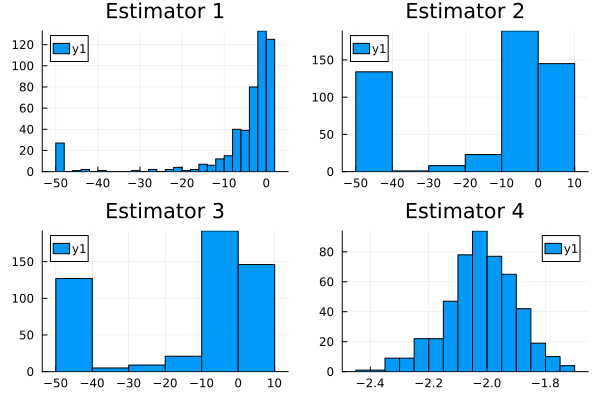

In [7]:
plot((histogram(ρb[i,:],title = "Estimator $i") for i in 1:4)...)

Next we evaluate each estimator for different sample sizes and levels of price variation. We present bias and standard error calculations for $\rho$ and $a$.

In [8]:
using DataFrames
σπ_vec = [0.5,1.,1.5]
N_vec = [500,1_000,2_000]

da = DataFrame(σπ = [], N = [], estimator = [], bias = [], sd = [])
dρ = DataFrame(σπ = [], N = [], estimator = [], bias = [], sd = [])

for i in 1:3
    for j in 1:3
       p = (;p...,σπ = σπ_vec[i])
       ρb,ab = monte_carlo(N_vec[j],500,p)
       da = [da; DataFrame(σπ = σπ_vec[i], N = N_vec[j], estimator = 2:4, bias = p.a .- mean(ab,dims=2)[:], sd = std(ab,dims=2)[:])]
       dρ = [dρ; DataFrame(σπ = σπ_vec[i], N = N_vec[j], estimator = 1:4, bias = p.ρ .- mean(ρb,dims=2)[:], sd = std(ρb,dims=2)[:])]
    end
end


The table below presents bias and standard error calculations for $\rho$.

In [9]:
using DataFramesMeta

@chain stack(dρ,[:bias,:sd]) begin
    @transform :variable = string.(:variable,"-",:estimator)
    @select :σπ :N :variable :value
    unstack()
end



Row,σπ,N,bias-1,bias-2,bias-3,bias-4,sd-1,sd-2,sd-3,sd-4
,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any
1,0.5,500,11.0073,18.6536,18.5067,0.035795,19.9523,23.7425,23.6915,0.255371
2,0.5,1000,8.62262,14.689,15.0168,0.010896,17.4532,22.2907,22.4292,0.178391
3,0.5,2000,3.28415,9.67366,10.3335,0.00574299,10.1598,18.9264,19.4438,0.125447
4,1.0,500,3.97255,11.3781,11.0292,-0.000566892,12.4946,20.3318,20.0544,0.120673
5,1.0,1000,1.6793,8.51165,8.03707,0.00575928,6.96961,17.9294,17.3108,0.08889
6,1.0,2000,0.469972,3.01433,3.08124,0.000466805,2.67343,11.0454,11.1557,0.0604359
7,1.5,500,1.76305,8.8333,8.67271,-0.000178552,7.62999,17.9798,17.7947,0.0797464
8,1.5,1000,0.753419,4.2446,4.24546,-0.000447586,4.66224,12.6541,12.7246,0.0578946
9,1.5,2000,0.139352,1.35036,1.39518,0.000955579,1.11186,6.80735,6.90033,0.0445468


Notice that while estimator 4 (which exploits cross-equation restrictions between production and relative demand) exhibit good performance in all scenarios, estimators 1-3 perform poorly even with larger sample sizes and (likely unreasonable) amounts of price variation.

Results below for estimates of $a$ demonstrate similar relative performance, but the difference in performance for factor shares does not appear to be as severe.

In [10]:
@chain stack(da,[:bias,:sd]) begin
    @transform :variable = string.(:variable,"-",:estimator)
    @select :σπ :N :variable :value
    unstack()
end


Row,σπ,N,bias-2,bias-3,bias-4,sd-2,sd-3,sd-4
,Any,Any,Any,Any,Any,Any,Any,Any
1,0.5,500,-0.0212861,-0.0221423,-0.000486233,0.376669,0.373523,0.00983093
2,0.5,1000,0.00995717,0.0161737,0.00056887,0.333632,0.334772,0.00702606
3,0.5,2000,-0.00868705,-0.00511394,-0.000163634,0.259439,0.263355,0.0052001
4,1.0,500,-0.0207732,-0.021613,0.000157503,0.281037,0.280427,0.0102048
5,1.0,1000,-0.0148324,-0.0144731,0.00012143,0.243821,0.239873,0.00708407
6,1.0,2000,0.000964469,0.00218039,0.000472783,0.157016,0.159175,0.00474059
7,1.5,500,-0.0166888,-0.015874,-3.08729e-5,0.252014,0.251896,0.00993578
8,1.5,1000,-0.00342402,-0.00266248,8.27412e-5,0.172073,0.172281,0.00695551
9,1.5,2000,-0.00334473,-0.00211959,6.32556e-5,0.108265,0.110355,0.00498878


## Collinearity in demand causes the problem

We finally include a simulation to show that collinearity in demand is the main cause of poor performance for direct estimation. To demonstrate this we evaluate the direct estimator under the assumption that $x_{1}$ and $x_{2}$ vary independently with the same variance as the previous example.

The code block below evaluates the estimator under this alternative data generating process and compares it to the original results when $x_{2}$ is determined by relative demand ("Collinear variation").

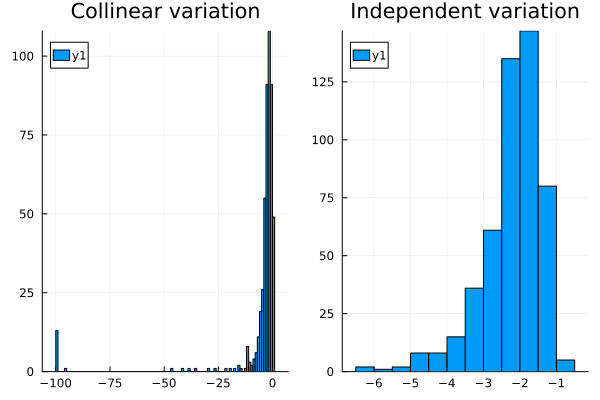

In [11]:
function gen_data2(p,N)
    (;a,ρ,σξ,δ,σπ) = p
    x1 = rand(LogNormal(3.,1),N)
    sig_x2 = sqrt(1 + σπ^2/(1-ρ)^2)
    x2 = rand(LogNormal(3.,sig_x2),N)
    logy = δ * log.( (a .* x1 .^ ρ .+ (1 - a) .* x2 .^ ρ ) .^ (1/ρ) ) .+ rand(Normal(0,σξ),N)
    return (;logy,x1,x2)
end


function monte_carlo_2(N,B,p)
    ρb = zeros(2,B)
    for b in 1:B
        #println("Doing round $b of $B trials")
        dat = gen_data(p,N)
        res1 = optimize(x->Q1_nlls((;p...,ρ=x),dat),-100.,1.) #[-2.]) #-300,1.) 
        dat = gen_data2(p,N)
        res2 = optimize(x->Q1_nlls((;p...,ρ=x),dat),-100.,1.) #[-2.]) #-300,1.) 
        ρb[:,b] .= (res1.minimizer,res2.minimizer)
    end
    return ρb
end

ρb = monte_carlo_2(500,500,p)
plot(histogram(ρb[1,:],title="Collinear variation"),
    histogram(ρb[2,:],title="Independent variation"))


The simulation here exhibits much better behavior. To illustrate why, we compare the joint distributions of inputs in the two cases:

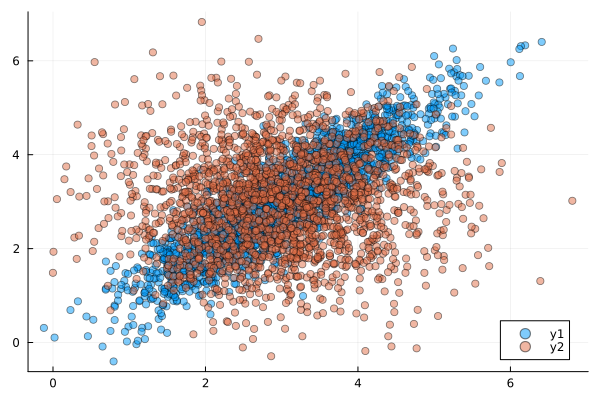

In [12]:
dat1 = gen_data(p,2_000)
dat2 = gen_data2(p,2_000)
scatter(log.(dat1.x1),log.(dat1.x2),markeralpha=0.5)
scatter!(log.(dat2.x1),log.(dat2.x2),markeralpha=0.5)

The correlation in inputs induced by complementarity seems to increase uncertainty in $\hat{\rho}$.